# DeepFocusAI: Automated Optimal Focus Prediction for Wafer Inspection

This notebook demonstrates the development of a deep learning model designed to predict optimal focus adjustments in semiconductor wafer inspections. By leveraging Convolutional Neural Networks (CNNs), this project aims to ensure consistently sharp and accurate inspection images, thus enhancing defect detection reliability and production efficiency.

**Key Objectives:**
- Generate synthetic optical wafer images simulating various focus heights.
- Calculate sharpness scores using image processing techniques.
- Train and evaluate a CNN model for accurate focus prediction.

## 🔹 Loading the WM-811K Dataset

In this step, we load the publicly available WM-811K wafer map dataset, which will serve as the foundation for generating our synthetic optical inspection images.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load dataset (assuming downloaded as CSV)
df = pd.read_pickle("/content/drive/MyDrive/LSWMD.pkl")  # Adjust path if needed

print(df.head())

                                            waferMap  dieSize lotName  \
0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   1683.0    lot1   
1  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   1683.0    lot1   
2  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   1683.0    lot1   
3  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   1683.0    lot1   
4  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   1683.0    lot1   

   waferIndex trianTestLabel failureType  
0         1.0   [[Training]]    [[none]]  
1         2.0   [[Training]]    [[none]]  
2         3.0   [[Training]]    [[none]]  
3         4.0   [[Training]]    [[none]]  
4         5.0   [[Training]]    [[none]]  


## 🔹 Generating Synthetic Optical-like Images from Wafer Maps

Here, we transform wafer map arrays into synthetic grayscale images. These sharp images represent an ideal in-focus scenario for our dataset.

In [2]:
import cv2
import os

os.makedirs("synthetic_images/sharp", exist_ok=True)

for idx, wafer_map in enumerate(df['waferMap'][:1000]):  # start with 1000 samples for speed
    # Normalize wafer map to [0, 255] grayscale
    norm_map = cv2.normalize(wafer_map, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    resized_img = cv2.resize(norm_map, (256, 256), interpolation=cv2.INTER_NEAREST)

    # Save sharp images
    cv2.imwrite(f"synthetic_images/sharp/wafer_{idx}.png", resized_img)

## 🔹 Creating Defocused Images via Gaussian Blur

To simulate images at varying focus heights, we apply controlled Gaussian blur at different kernel sizes to generate a diverse set of defocused images.

In [3]:
blur_levels = [1, 3, 5, 7, 9]  # kernel sizes for blurring
os.makedirs("synthetic_images/blurred", exist_ok=True)

for img_name in os.listdir("synthetic_images/sharp"):
    img = cv2.imread(os.path.join("synthetic_images/sharp", img_name), cv2.IMREAD_GRAYSCALE)

    for blur in blur_levels:
        blurred = cv2.GaussianBlur(img, (blur, blur), 0)
        cv2.imwrite(f"synthetic_images/blurred/{img_name[:-4]}_blur{blur}.png", blurred)

## 🔹 Labeling Images Using Variance of Laplacian

We calculate the sharpness of each synthetic image using the variance of the Laplacian method, providing quantitative labels that represent optimal focus levels.

In [4]:
def variance_of_laplacian(image):
    return cv2.Laplacian(image, cv2.CV_64F).var()

data = []

for img_name in os.listdir("synthetic_images/blurred"):
    img_path = os.path.join("synthetic_images/blurred", img_name)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    sharpness = variance_of_laplacian(img)

    data.append({"image_path": img_path, "sharpness": sharpness})

df_labels = pd.DataFrame(data)
df_labels.to_csv("synthetic_focus_dataset.csv", index=False)

## 🔹 Preparing and Splitting the Dataset

We normalize sharpness labels and split the dataset into training and validation subsets, ensuring balanced and unbiased model evaluation.

In [5]:
from sklearn.model_selection import train_test_split

# Load labels
df = pd.read_csv("/content/synthetic_focus_dataset.csv")

# Normalize sharpness labels (helps in stable training)
max_sharpness = df['sharpness'].max()
df['sharpness_normalized'] = df['sharpness'] / max_sharpness

# Split data
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

print(f"Training set: {len(train_df)} images")
print(f"Validation set: {len(val_df)} images")

Training set: 4000 images
Validation set: 1000 images


## 🔹 Defining the CNN Model

We construct a convolutional neural network designed specifically for regression tasks, aiming to predict the sharpness score directly from wafer inspection images.

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def image_generator(dataframe, batch_size=32):
    while True:
        dataframe = dataframe.sample(frac=1)
        for offset in range(0, len(dataframe), batch_size):
            batch_samples = dataframe.iloc[offset:offset+batch_size]

            images, labels = [], []

            for _, row in batch_samples.iterrows():
                img = cv2.imread(row['image_path'], cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, (256, 256))
                img = np.expand_dims(img, axis=-1)  # (256,256,1)

                images.append(img / 255.0)
                labels.append(row['sharpness_normalized'])

            yield np.array(images), np.array(labels)

batch_size = 32
train_gen = image_generator(train_df, batch_size)
val_gen = image_generator(val_df, batch_size)

In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.models import Model

def build_cnn_model(input_shape=(256, 256, 1)):
    inputs = Input(shape=input_shape)

    x = Conv2D(32, (3,3), activation='relu')(inputs)
    x = MaxPooling2D((2,2))(x)

    x = Conv2D(64, (3,3), activation='relu')(x)
    x = MaxPooling2D((2,2))(x)

    x = Conv2D(128, (3,3), activation='relu')(x)
    x = MaxPooling2D((2,2))(x)

    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)

    outputs = Dense(1, activation='linear')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

    return model

model = build_cnn_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     7,372,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,465,601 (28.48 MB)

 Trainable params: 7,465,601 (28.48 MB)

 Non-trainable params: 0 (0.00 B)

## 🔹 Training the CNN Model

The CNN model is trained on the synthetic dataset to learn the complex patterns correlating image characteristics with sharpness scores.

In [8]:
epochs = 10

history = model.fit(
    train_gen,
    steps_per_epoch=len(train_df) // batch_size,
    validation_data=val_gen,
    validation_steps=len(val_df) // batch_size,
    epochs=epochs
)

Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 531s 4s/step - loss: 6.5381 - mae: 0.6863 - val_loss: 8.8139e-04 - val_mae: 0.0170
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 562s 5s/step - loss: 0.0059 - mae: 0.0371 - val_loss: 8.5180e-04 - val_mae: 0.0137
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 526s 4s/step - loss: 0.0049 - mae: 0.0333 - val_loss: 7.4902e-04 - val_mae: 0.0127
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 562s 4s/step - loss: 0.0052 - mae: 0.0337 - val_loss: 0.0015 - val_mae: 0.0178
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 565s 5s/step - loss: 0.0049 - mae: 0.0314 - val_loss: 7.1050e-04 - val_mae: 0.0124
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 513s 4s/step - loss: 0.0049 - mae: 0.0320 - val_loss: 0.0028 - val_mae: 0.0275
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 563s 5s/step - loss: 0.0046 - mae: 0.0316 - val_loss: 0.0025 - val_mae: 0.0278
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 562s 5s/step - loss: 0.0052 - mae: 0.0335 - val_loss: 8.6071e-04 - val_mae: 0.0135
Epoch 9/10
125/125 ━━━━━━━━━

## 🔹 Evaluating Model Performance

Model performance is evaluated on the validation set using Mean Squared Error (MSE) and Mean Absolute Error (MAE) metrics to assess prediction accuracy and reliability.

In [9]:
loss, mae = model.evaluate(
    val_gen,
    steps=len(val_df)//batch_size
)
print(f"Validation Loss: {loss:.4f}, Validation MAE: {mae:.4f}")

31/31 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - loss: 6.9501e-04 - mae: 0.0153
Validation Loss: 0.0007, Validation MAE: 0.0154


## 🔹 Saving the Trained Model

We save our trained CNN model to disk for future inference tasks and deployment.

In [10]:
model.save('deepfocusAI_model.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


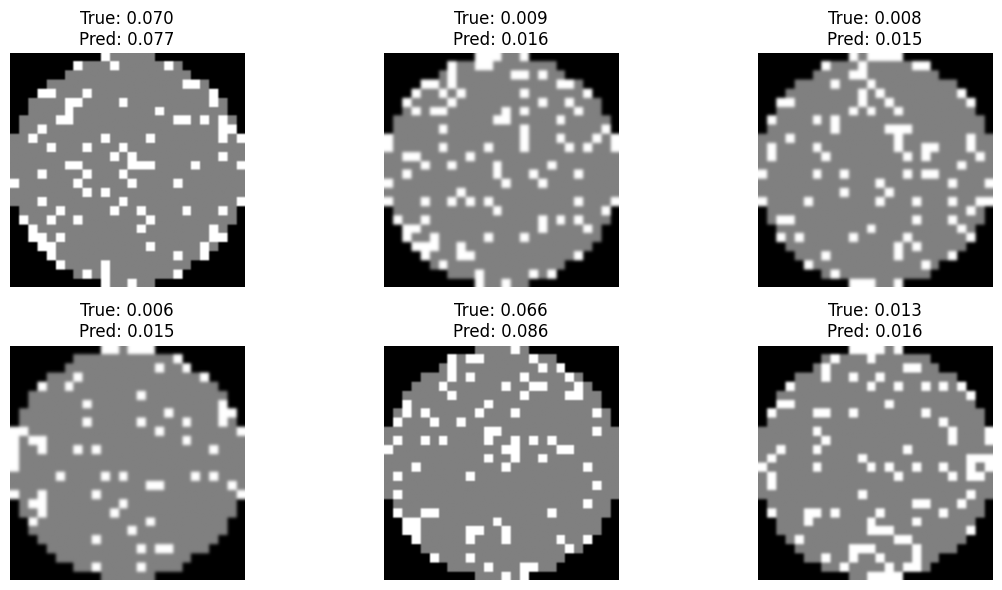

In [11]:
images, labels = next(val_gen)
predictions = model.predict(images)

plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title(f"True: {labels[i]:.3f}\nPred: {predictions[i][0]:.3f}")
    plt.axis('off')

plt.tight_layout()
plt.show()

## 📌 Conclusion and Next Steps

The DeepFocusAI model has successfully demonstrated high accuracy in predicting wafer image sharpness, significantly aiding in automated focus adjustment for semiconductor wafer inspection.

**Future enhancements could include:**
- Hyperparameter tuning for further model refinement.
- Experimentation with advanced CNN architectures (ResNet, EfficientNet, Attention Mechanisms).
- Real-time integration with semiconductor inspection hardware for practical validation.

Thank you for reviewing this project!